# Profiles of supergranule flow and vector potential

In [1]:
from __future__ import division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import pyfits
import plotc
import read_params
np.set_printoptions(precision=3)
import scipy.integrate
import dbyd2
%load_ext Cython

In [2]:
c,rho = np.loadtxt(read_params.get_solarmodel(),usecols=[1,2],unpack=True)
c.shape += (1,)
rho.shape += (1,)
c = c/100 # Convert to m/s

In [3]:
def fitsread(f): return np.squeeze(pyfits.getdata(f))

In [4]:
vx = fitsread('true_vx.fits')
vz = fitsread('true_vz.fits')
true_psi = fitsread('true_psi.fits')
Lregular = 30 #Mm, required to convert psi to Mm, see driver.f90
true_psi *= Lregular

In [5]:
Lx=read_params.get_xlength()
nx=read_params.get_nx()
x=np.linspace(-Lx/2,Lx/2,nx,endpoint=False)
z=np.loadtxt(read_params.get_solarmodel(),usecols=[0])
z=(z-1)*695.8

def ind_x(x): return int((x/Lx+1/2)*nx)
def ind_z(z_coord): return abs(z-z_coord).argmin()

z_surf=ind_z(0)

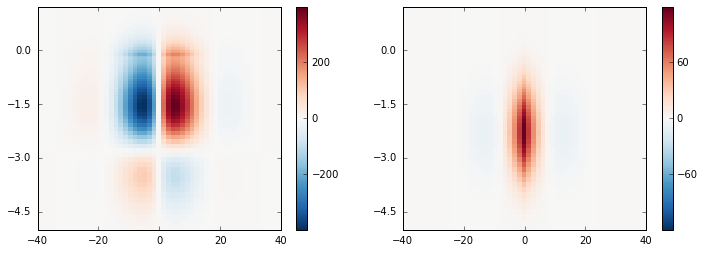

In [6]:
plotc.colorplot(vx,x=x,y=z,xr=[-40,40],yr=[-5,None],sp=121,centerzero=True);
plotc.colorplot(vz,x=x,y=z,xr=[-40,40],yr=[-5,None],sp=122,centerzero=True);
plt.gcf().set_size_inches(12,4)

Let's derive the velocity fields from the vector potential. In Cartesian coordinates the velocity field is related to the potential through 

$$ v_{x}	=	-\frac{1}{\rho}\partial_{z}\left[\rho c\psi\right], \\
v_{z}	=	\frac{1}{\rho}\partial_{x}\left[\rho c\psi\right]. $$

In [7]:
# This cell is to test dbyd2
dbyd2_z = np.zeros((1,)+z.shape,order='F')
dbyd2.dbyd2(dbyd2_z,np.asfortranarray(np.atleast_2d(z)),1)
print dbyd2_z.shape,dbyd2_z.any()

(1, 300) True


In [42]:
def ddz(arr): return np.gradient(arr)[0]/np.gradient(z)[:,np.newaxis]
def ddz_dbyd2(arr):
    arr = np.asfortranarray(arr).T
    numerator = np.zeros(arr.shape,order='F')
    dbyd2.dbyd2(numerator,arr,1)
    return (numerator/dbyd2_z).T

In [87]:
%%cython
import numpy as np
cimport numpy as np
import scipy.fftpack
import read_params
Lx = read_params.get_xlength()

cpdef fft_deriv_x(arr):
    cdef int zind
    cdef np.ndarray[np.float64_t, ndim=2] darr = np.zeros_like(arr)
    cdef np.ndarray[np.float64_t,ndim=1] az
    for zind,az in enumerate(arr):
        darr[zind]=scipy.fftpack.diff(az,period=float(Lx))
    return darr

cpdef fft_int_x(arr):
    cdef int zind,nx
    cdef float az_mean
    nx = arr.shape[1]
    cdef np.ndarray[np.float64_t, ndim=2] darr = np.zeros_like(arr)
    cdef np.ndarray[np.float64_t,ndim=1] x=np.linspace(-Lx/2.,Lx/2.,nx,endpoint=False)
    cdef np.ndarray[np.float64_t,ndim=1] az
    
    for zind,az in enumerate(arr):
        az_mean = np.mean(az)
        darr[zind]=scipy.fftpack.diff(az-az_mean,period=Lx,order=-1)
        darr[zind]+=az_mean*(x+Lx/2.)
        
    return darr

In [50]:
vx_from_psi = -1/rho*ddz(rho*c*true_psi)
vx_from_psi_2 = -1/rho*ddz_dbyd2(rho*c*true_psi)

In [80]:
vz_from_psi = 1/rho*np.gradient(rho*c*true_psi)[1]/np.gradient(x)
vz_from_psi_fft = 1/rho*fft_deriv_x(rho*c*true_psi)

Mean all close to zero in fft derived vz: True


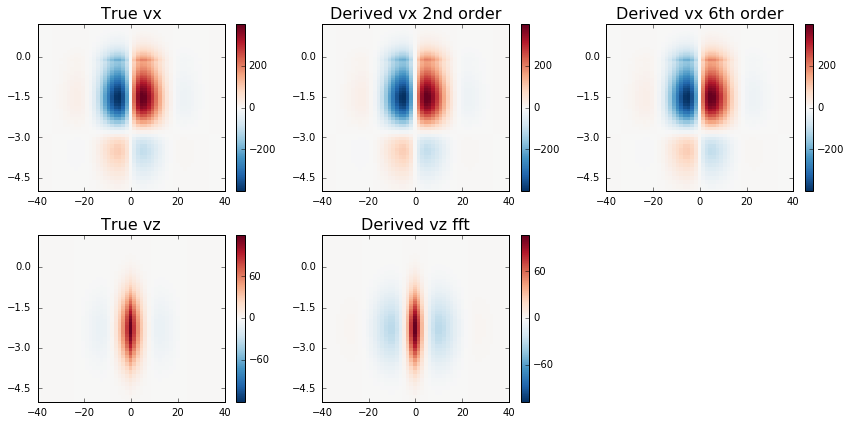

In [84]:
plotc.colorplot(vx,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=231);
plt.title("True vx",fontsize=16)
plotc.colorplot(vx_from_psi,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=232);
plt.title("Derived vx 2nd order",fontsize=16)
plotc.colorplot(vx_from_psi_2,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=233);
plt.title("Derived vx 6th order",fontsize=16)

plotc.colorplot(vz,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=234);
plt.title("True vz",fontsize=16)
plotc.colorplot(vz_from_psi_fft,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=235);
plt.title("Derived vz fft",fontsize=16)

print "Horizontal mean all close to zero in fft derived vz:",np.isclose(np.mean(vz_from_psi_fft,axis=1),0).all()

plt.gcf().set_size_inches(12,6);
plt.tight_layout()

The vector potential that gives rise to these velocity fields can be computed in polar as well as Cartesian coordinates. The difference is that the vector potential is along $\mathbf{e}_\phi$ in polar and $\mathbf{e}_y$ in Cartesian. 

### Cartesian coordinates
 
 $$ \psi\left(x,z\right)=\frac{1}{\rho\left(z\right)c\left(z\right)}\int_{-L_x/2}^{x}dx^{\prime}\,\rho\left(z\right)v_{z}\left(x^{\prime},z\right).$$
 
or alternately in terms of $v_x$
 
 $$ \psi\left(x,z\right)=-\frac{1}{\rho\left(z\right)c\left(z\right)}\int_{z_{b}}^{z}dz^{\prime}\,\rho\left(z^{\prime}\right)v_{x}\left(x,z^{\prime}\right).$$

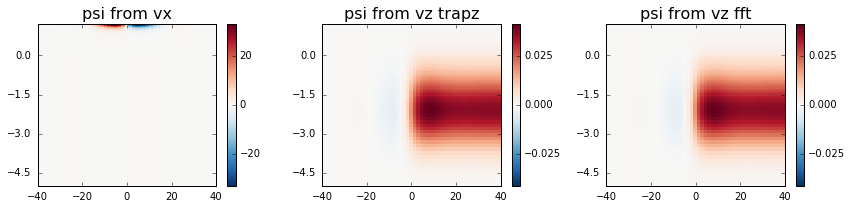

In [94]:
psi_int_cart_vx = -scipy.integrate.cumtrapz(rho*vx,x=z,axis=0,initial=0)/(rho*c)
plotc.colorplot(psi_int_cart_vx,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=131);
plt.title("psi from vx",fontsize=16)

psi_int_cart_vz = scipy.integrate.cumtrapz(rho*vz,x=x,axis=1,initial=0)/(rho*c)
plotc.colorplot(psi_int_cart_vz,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=132);
plt.title("psi from vz trapz",fontsize=16)

psi_int_cart_vz_fft = fft_int_x(rho*vz)/(rho*c)
plotc.colorplot(psi_int_cart_vz_fft,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=133);
plt.title("psi from vz fft",fontsize=16)

plt.gcf().set_size_inches(12,3)
plt.tight_layout()

psi_int_cart_vx=None
psi_int_cart_vz=None
psi_int_cart_vz_fft=None

What is going on? Let's do a sanity check.

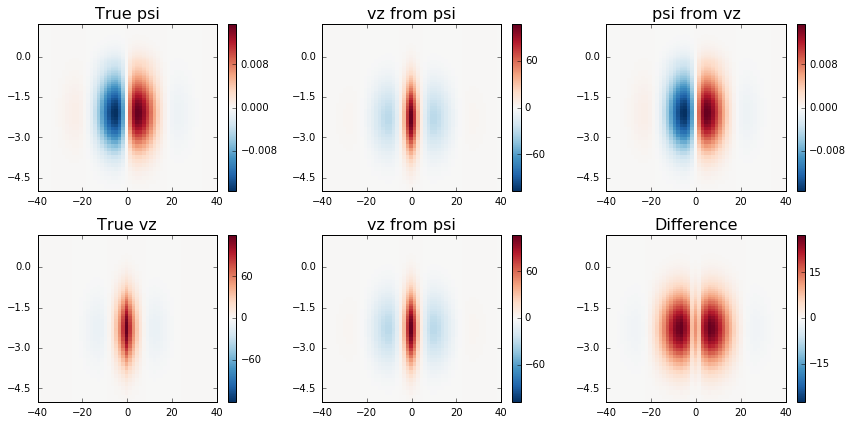

In [98]:
plotc.colorplot(true_psi,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=231);
plt.title("True psi",fontsize=16)

vz_from_psi = fft_deriv_x(rho*c*true_psi)/rho
plotc.colorplot(vz_from_psi,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=232);
plt.title("vz from psi",fontsize=16)

psi_from_vz_from_psi = fft_int_x(rho*vz_from_psi)/(rho*c)
plotc.colorplot(psi_from_vz_from_psi,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=233);
plt.title("psi from vz",fontsize=16)

plotc.colorplot(vz,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=234);
plt.title("True vz",fontsize=16)
plotc.colorplot(vz_from_psi,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=235);
plt.title("vz from psi",fontsize=16)
plotc.colorplot(vz-vz_from_psi,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=236);
plt.title("Difference",fontsize=16)

plt.gcf().set_size_inches(12,6)
plt.tight_layout()

vz_from_psi=None
psi_from_vz_from_psi=None

We can use derived vz to intergate and compute the vector potential, instead of true vz. The value of $\psi$ above the surface is:

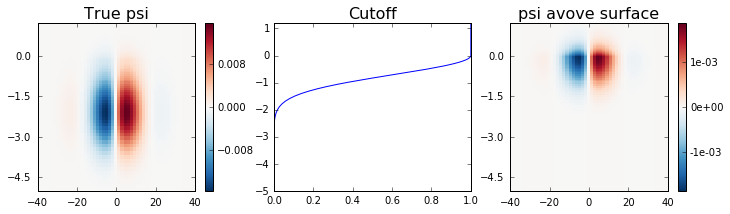

In [148]:
plotc.colorplot(true_psi,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=131);
plt.title("True psi",fontsize=16)

cutoff = z**2/1
cutoff[cutoff>100]=100
cutoff[z_surf:]=0.
cutoff = np.exp(-cutoff)
cutoff.shape += (1,)
psi_above_surface = true_psi.copy()
psi_above_surface[:z_surf] = np.tile(np.atleast_2d(psi_above_surface[z_surf]),(z_surf,1))
psi_above_surface*=cutoff

plt.subplot(132)
plt.plot(cutoff,z);
plt.ylim(-5,z[-1])
plt.title("Cutoff",fontsize=16)

plotc.colorplot(psi_above_surface,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=133);
plt.title("psi at surface",fontsize=16)

plt.gcf().set_size_inches(12,3)

Velocity corresponding to surface matched potential

In [ ]:
vx_starting = -ddz_dbyd2(rho*c*psi_above_surface)/rho
vz_starting = fft_deriv_x(rho*c*psi_above_surface)/rho

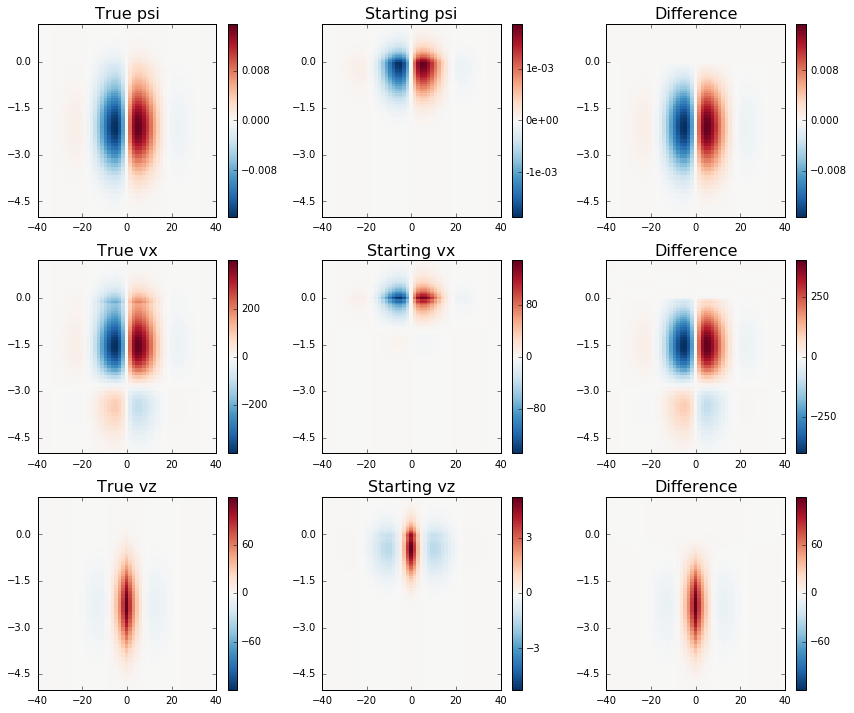

In [155]:
gl=plotc.gridlist(3,3)

plotc.colorplot(true_psi,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("True psi",fontsize=16)

plotc.colorplot(psi_above_surface,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Starting psi",fontsize=16)

plotc.colorplot(true_psi-psi_above_surface,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Difference",fontsize=16)

plotc.colorplot(vx,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("True vx",fontsize=16)

plotc.colorplot(vx_starting,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Starting vx",fontsize=16)

plotc.colorplot(vx-vx_starting,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Difference",fontsize=16)

plotc.colorplot(vz,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("True vz",fontsize=16)

plotc.colorplot(vz_starting,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Starting vz",fontsize=16)

plotc.colorplot(vz-vz_starting,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Difference",fontsize=16)

plt.gcf().set_size_inches(12,10)
plt.tight_layout()